# Token Alignment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from genparse import EarleyLM as CFGLM
from genparse.cfglm import locally_normalize, EOS
from genparse.proposal import CharacterProposal, TokenProposal
from genparse.util import display_table
from genparse.trace import generation_tree
from genparse.segmentation import bpe_wfst, segmentation_pfst
from genparse.lm import MockLLM

$$
\newcommand{\aa}[0]{\boldsymbol{a}}
\newcommand{\bb}[0]{\boldsymbol{b}}
\newcommand{\AA}[0]{\mathcal{A}}
\newcommand{\BB}[0]{\mathcal{B}}
$$

Let $p$ be a distribution over character strings $\aa \in \AA^*$.

Let $p'$ be a distribution over BPE strings $\bb \in \BB^*$.

Let $\phi\colon \BB^* \to \AA^*$ be a decoding function. The decoding function satisfies: $\phi(\bb \, \bb') = \phi(\bb) \, \phi(\bb')$ for all $\bb, \bb' \in \BB^*$.  In other words, $\phi$ is a **monoid homomorphism**.

In [3]:
p = CFGLM.from_string(
    """

1: S -> a
1: S -> a a
2: S -> a a a

"""
)

A = p.cfg.V
B = {'a', 'aa', 'aaa', EOS}
ϕ = lambda b: ''.join(b).strip(EOS)

Our goal is to transform the distribution $p$ into a distribution $p'$ such that the following correctness condition holds:

**Correctness Condition:**

$$
\forall \aa \in \AA\colon\quad   p(\aa) = \sum_{\bb\colon\ \phi(\bb) = \aa} p'(\bb)
$$

The correctness condition ensures that the process: $\bb \sim p'$, $\aa = \phi(\bb)$ generates $\aa$ that is distributed $p$.

**A stochastic tokenization model:**

$$
p'(\bb) = \sum_{\aa} \, p(\aa) \, \!\!\!\!\!\!\!\!\!\!\underbrace{p(\bb \mid \aa)}_{\substack{\text{probabilistic transducer} \\ \text{where } \phi(\bb) = \aa \text{ holds } w.p.1 }}
$$


When $p$ is PCFG-LMs, we may use composition with any segmentation PFST to construction $p'$.

**Tokenization Preferences.**
It is possible to satisfy the correctness conditions in undesirable ways because they would adversely affect the downstream components.
Consider the following **unwanted workaround** for BPE tokenization.  In that case, we have, by construction, individual characters included in the token vocabulary.  This means we can define a trivial segmentation that only takes unit-length segments as the only tokenization with nonzero probability.  This will not be the preferred prediction scheme of the LLM model, as it will generally prefer the segments that are more representative of those appearing in this context in the training data.  These tend to be the longest-matching tokens.  Some LMs are trained with subword-regularization schemes, which may make them more robust to the specific segmentation.  These are design choices, we suggested that relatively flat distributions over segmentations will likely work best.  However, the maximum-match version has computational benefits.

### Token Proposal

Below, we explore some preliminary attempts to understand the distortion in the char-alignment adaptor (I might refer to this as "grafting" or a more global transduction-based approach).

The class `CharAlignedCFGLM` implements an LM $q$ over tokens based on the following conditional factorization:

$$
q(b_{N+1} \mid b_1, \ldots, b_N) \propto p( a_{N+1} \mid a_1 \cdots a_N )
$$

where $b_1, \ldots, b_N$ are a sequence of tokens ids, and $a_1, \ldots, a_N$ are their respective strings in $\mathcal{A}^*$ (i.e., $\phi(b_k) = a_k$ for each $k = 1, \ldots, N$).

In [4]:
llm = MockLLM(B, EOS)

In [5]:
graft = TokenProposal(guide=p, llm=llm)

Our target distribution is the following

In [6]:
generation_tree(p)

key,value
"('a',)",0.25
"('a', 'a')",0.25
"('a', 'a', 'a')",0.5


In [7]:
generation_tree(graft)

key,value
a,0.0855614973262032
aa,0.2032085561497326
aaa,0.7112299465240641


In [8]:
generation_tree(graft, chunked=True)

key,value
"('a',)",0.0855614973262032
"('a', 'a')",0.08556149732620319
"('a', 'a', 'a')",0.17112299465240638
"('a', 'aa')",0.1283422459893048
"('aa',)",0.11764705882352941
"('aa', 'a')",0.23529411764705882
"('aaa',)",0.17647058823529413


### Weighted Transducer

The following WFST simulates the BPE's desire to create chunks from character sequences.

In [9]:
T = bpe_wfst((b, tuple(b)) for b in B).T

We can push some specific character strings throught the transducer to see all of the ways that can be chunked.

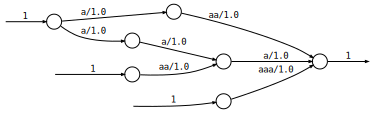

In [10]:
T('aaa', None).epsremove.trim

In [11]:
T('aaa', None).total_weight()

4.0

In [12]:
b_lm = CFGLM(locally_normalize((p.cfg @ T).trim(), tol=1e-100).trim())

In [13]:
L = b_lm.cfg.language(10)

In [14]:
generation_tree(b_lm)

key,value
"('a',)",0.0909090909090909
"('a', 'a')",0.0909090909090909
"('a', 'a', 'a')",0.1818181818181818
"('a', 'aa')",0.1818181818181818
"('aa',)",0.0909090909090909
"('aa', 'a')",0.1818181818181818
"('aaa',)",0.18181818181818182


In [15]:
PL = L.project(ϕ)
PL

key,value
a,0.0909090909090909
aa,0.1818181818181818
aaa,0.7272727272727273


In [16]:
display_table(
    [[p.cfg.language(100).project(ϕ), generation_tree(graft).D, PL]],
    headings=['target', 'token-proposal', 'composition'],
)

### The Probabilistic Segmentation Model

In [17]:
PT = segmentation_pfst(B, p.cfg.V - {EOS}, canonical=True)

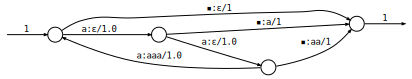

In [18]:
PT

In [19]:
# pb_lm = CFGLM(locally_normalize((p.cfg @ PT).trim()).trim())
pb_lm = CFGLM((p.cfg @ PT).trim())

In [20]:
generation_tree(pb_lm)

key,value
"('a',)",0.25
"('aa',)",0.25
"('aaa',)",0.5


In [21]:
L_PB = pb_lm.cfg.language(100).project(ϕ)
L_PB

key,value
a,0.25
aa,0.25
aaa,0.5


In [22]:
L_PB.assert_equal(p.cfg.language(100).project(ϕ))  # character-level distribution matches!

In [23]:
display_table(
    [
        [
            p.cfg.language(100).project(ϕ).sort(),
            L_PB.sort(),
            generation_tree(graft).D.sort(),
            PL.sort(),
        ]
    ],
    headings=['target', 'pfst', 'grafting-heuristic', 'wfst'],
)

### Character Proposal

In [24]:
from genparse.trace import TraceSWOR

In [25]:
c_proposal = CharacterProposal(guide=p, llm=llm)

('aaa', 0.3025210084033613, 0.009684244791666668)
('aaa', 0.24201680672268905, 0.0030263264973958335)
('aaa', 0.17647058823529413, 0.06640625)
('aaa', 0.1411764705882353, 0.020751953125)
('aa', 0.04033613445378151, 0.0726318359375)
('a', 0.047058823529411764, 0.33203125)
('aa', 0.05042016806722689, 0.232421875)


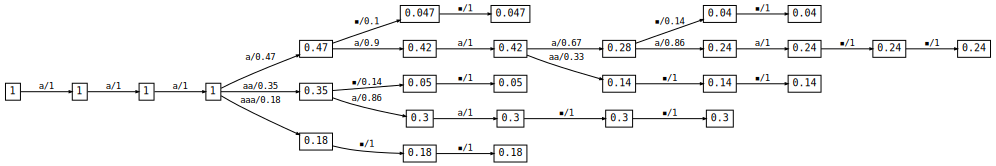

In [26]:
trace = TraceSWOR()
while trace.root.mass > 0:
    with trace:
        out = c_proposal.sample('', draw=trace)
        print(out)
trace

('aa', 0.3, 0.3125)
('a', 0.6, 0.3125)
('▪', 0.1, 0.625)


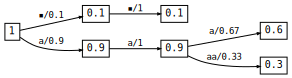

In [27]:
trace = TraceSWOR()
while trace.root.mass > 0:
    with trace:
        out = c_proposal._guided_sample_trie('a', draw=trace)
        print(out)
trace